In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ds = pd.read_csv('caras.csv')
ds.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,person_id
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


# 1. Inspección de los datos
El dataset caras.csv contiene 800 imágenes de 68 × 68 pixeles en escala de grises, junto con sus etiquetas de clase. Para realizar un análisis exploratorio de estos datos, se proponen los siguientes puntos:

## a) Graficar Imagenes
Implementar una función que pueda graficar un número arbitrario de imágenes del dataset. Mostrar un ejemplo de un gráfico con 15 imágenes seleccionadas de manera aleatoria.
Esta función va a ser necesaria a lo largo de todo el trabajo, por lo que se deberá ir adaptando de acuerdo a las necesidades que vayan surgiendo.

In [ ]:
def plot_random_img(ds, ds2=None, n_img=15, rand_seed=None):
    """
    Selecciona n_img imágenes aleatorias del dataset y las muestra en una grilla. Por defecto, muestra 15 imágenes.
    """
    sample = ds.sample(n_img, random_state=rand_seed)
    cols = min(n_img, 5)
    rows = int(np.ceil(n_img / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))
    ax = np.atleast_2d(ax)

    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx < n_img:
                img = sample.iloc[idx, :-1].values.reshape(64, 64)
                ax[i, j].imshow(img, cmap='gray')
                ax[i, j].axis('off')
                ax[i, j].set_title(f"ID: {sample.iloc[idx]['person_id']}", fontsize=8)
                idx += 1
            else:
                ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

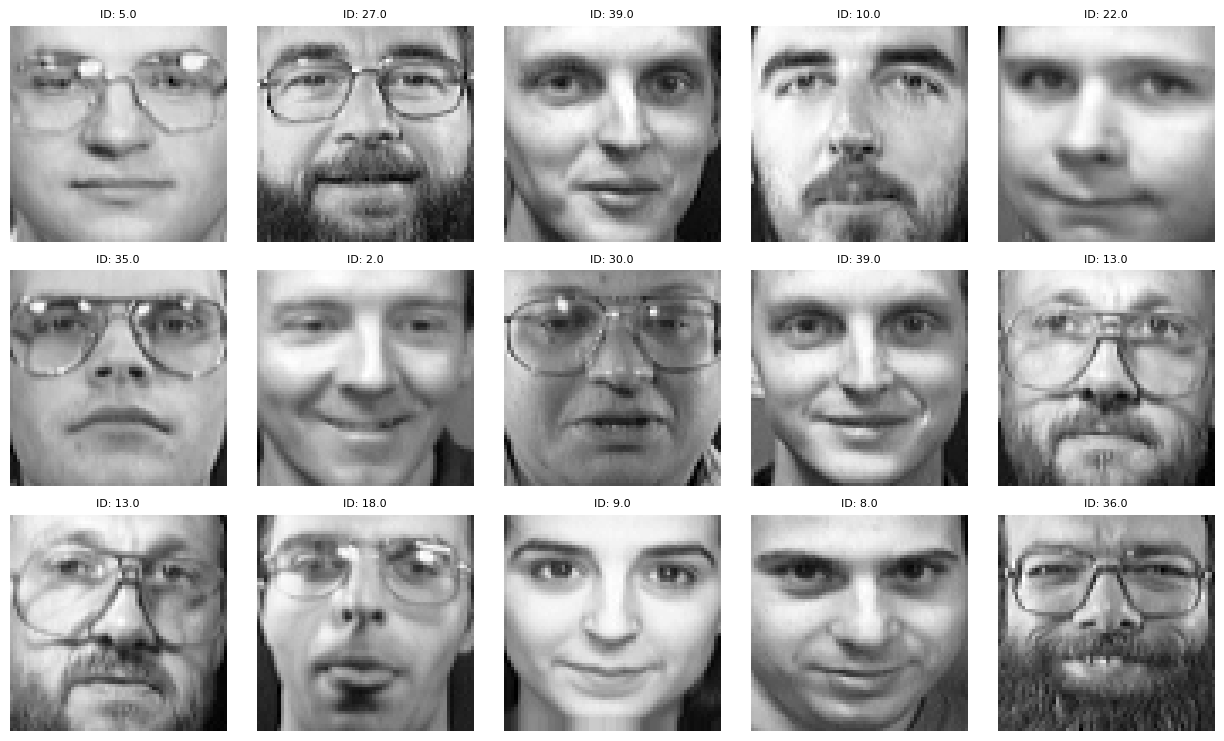

In [ ]:
plot_random_img(ds, n_img=15, rand_seed=43)

## b) Analizar distribucion por clase
Realizar un analisis exploratorio enfocado en la distribución de clases en los datos.

In [ ]:
def plot_distribution(ds, target_col='person_id'):
  ids = ds[target_col]
  counts = ids.value_counts().sort_index()
  classes = counts.index.to_numpy()
  values  = counts.values
  cmap = plt.get_cmap('tab20', len(classes))
  colors = [cmap(i) for i in range(len(classes))]

  plt.figure(figsize=(10,4))
  plt.bar(classes, values, color=colors, width=0.9)
  plt.xlabel('person_id')
  plt.ylabel('frecuencia')
  plt.xticks(classes)         # asegura ticks en cada clase
  plt.title('Distribución por clase')
  plt.tight_layout()
  plt.show()

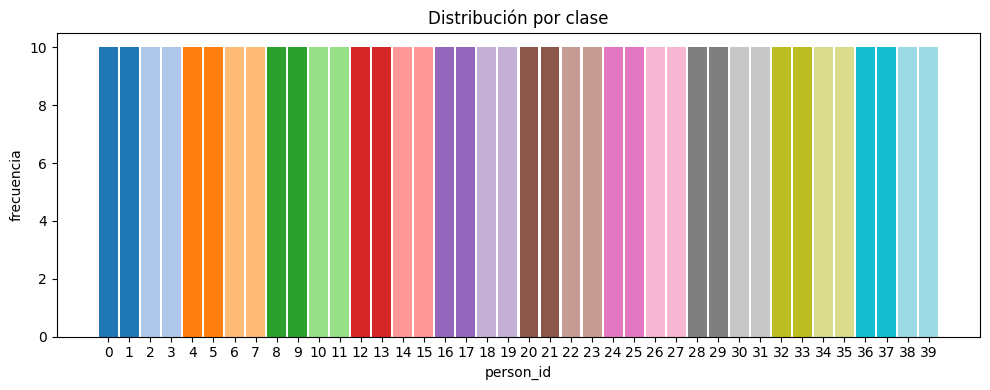

In [ ]:
plot_distribution(ds)

 Para tener una mejor noción de la variabilidad de las muestras, graficar muestras agrupadas por clase, para al menos 5 clases.

In [ ]:
def plot_by_class(ds, ids, num_img, rand_seed=None):
  """
    Recibe una lista de ids de personas y muestra 5 imágenes correspondientes a cada etiqueta id. Asume un minimo de 5 muestras por clase.
  """
  for id in ids:
    imgs = ds[ds['person_id'] == id].sample(num_img, random_state=rand_seed)
    cols = num_img
    rows = int(np.ceil(5 / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))
    ax = np.atleast_2d(ax)

    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx < num_img:
                img = imgs.iloc[idx, :-1].values.reshape(64, 64)
                ax[i, j].imshow(img, cmap='gray')
                ax[i, j].axis('off')
                ax[i, j].set_title(f"ID: {imgs.iloc[idx]['person_id']}", fontsize=8)
                idx += 1
            else:
                ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

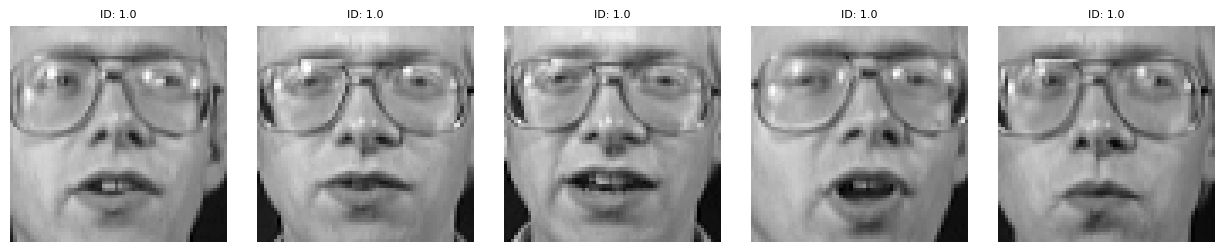

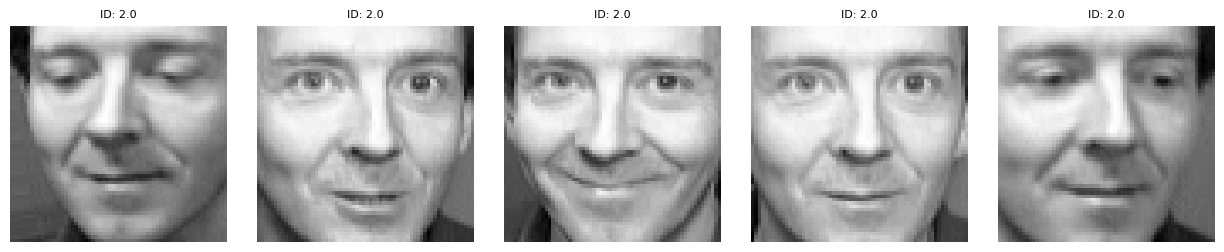

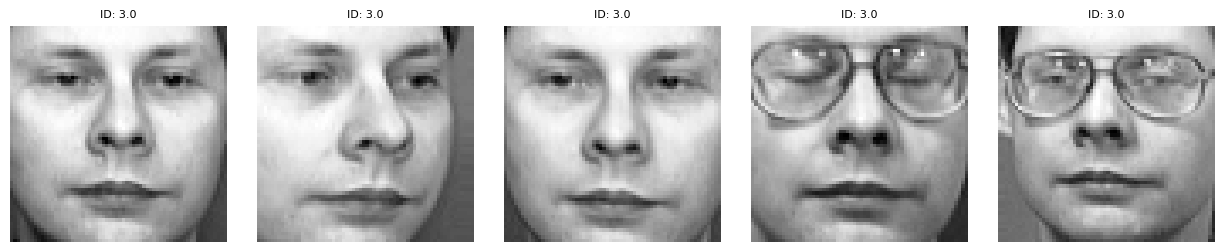

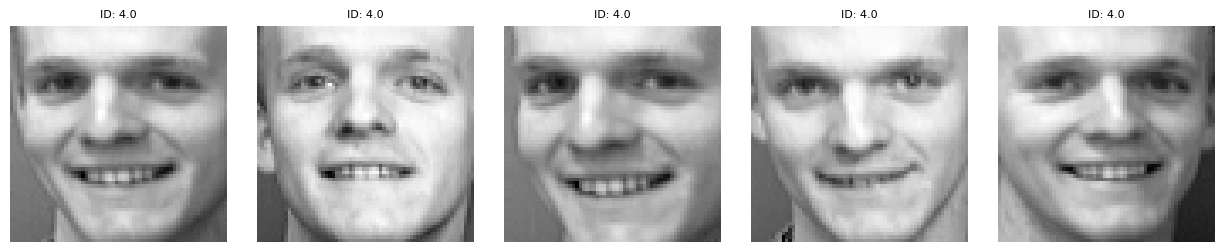

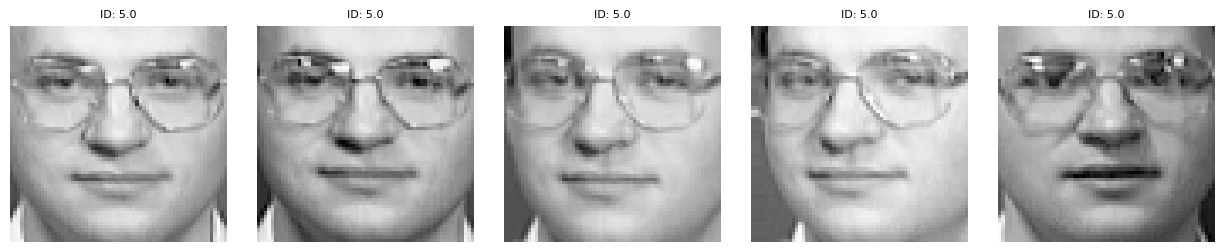

In [ ]:
plot_by_class(ds, [1, 2, 3, 4, 5], 5, rand_seed=43)

## c) Split de datos
Realizar un split de datos estratificado para conformar un conjunto de entrenamiento y otro de evaluación, en donde los datos de evaluación sean el 20 % del total.

In [ ]:
def stratified_split(df, label_col, test_size=0.2, rand_seed=None):
    """
    Divide el dataset en train/test manteniendo la proporción de clases.
    """
    np.random.seed(rand_seed)
    train_parts = []
    test_parts = []

    for cls, subset in df.groupby(label_col):
        n_test = int(len(subset) * test_size)
        shuffled = subset.sample(frac=1, random_state=rand_seed)
        test_parts.append(shuffled.iloc[:n_test])
        train_parts.append(shuffled.iloc[n_test:])

    df_train = pd.concat(train_parts).sample(frac=1, random_state=rand_seed).reset_index(drop=True)
    df_test  = pd.concat(test_parts).sample(frac=1, random_state=rand_seed).reset_index(drop=True)

    return df_train, df_test

In [ ]:
train, val = stratified_split(ds, 'person_id', test_size=0.2, rand_seed=43)

y_train = train['person_id'].to_numpy()
y_val = val['person_id'].to_numpy()

x_train = train.drop(columns=['person_id']).to_numpy()
x_val = val.drop(columns=['person_id']).to_numpy()

chequeo balances

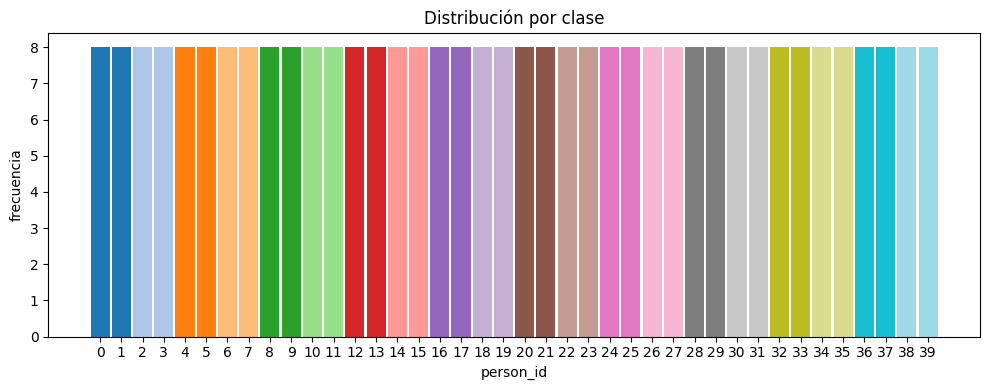

In [ ]:
plot_distribution(train)

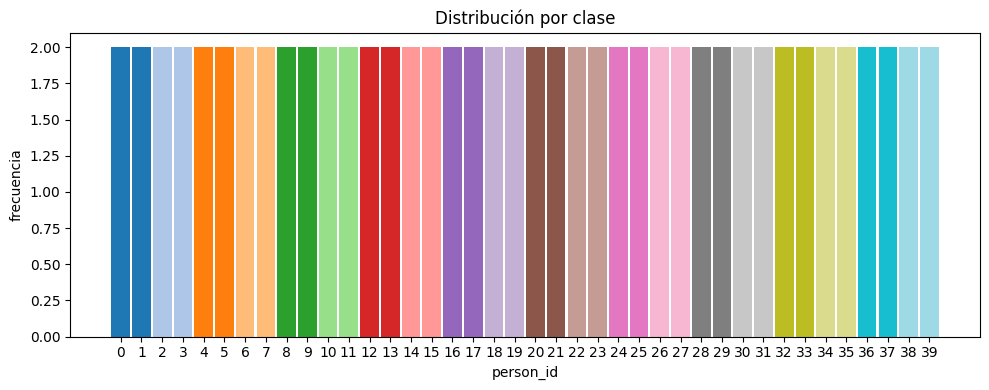

In [ ]:
plot_distribution(val)

# 2. Reducción de dimensionalidad

## a) Estandarización y PCA
Implementar una función para estandarizar los datos, y otra para realizar Principal Component Analysis (PCA). Estandarizar y aplicar PCA sobre los datos de entrenamiento. Con la transformacion aprendida previamente reducir la dimensionalidad de los datos de evaluacion.

### Estandarización:

In [ ]:
def standardize_per_image(df):
    """
    Estandariza cada imagen (fila) a media 0 y var 1 dentro de la misma imagen.
    """
    mu = df.mean(axis=1, keepdims=True)
    sigma = df.std(axis=1, keepdims=True)
    sigma[sigma == 0] = 1.0
    Xz = (df - mu) / sigma
    return Xz

In [ ]:
standardize_per_image(x_train)

array([[-0.74185825, -0.6097326 , -0.82113367, ..., -1.77243822,
        -1.82528852, -1.71958799],
       [-1.35722247, -1.35722247, -2.50366643, ..., -0.41459077,
        -0.64387955, -0.72030912],
       [ 1.01473764,  1.11850748,  1.14444977, ..., -0.9309441 ,
        -0.87905934, -0.98282906],
       ...,
       [-1.34813995, -1.22523904, -1.12691846, ...,  0.24957016,
         1.08529555,  1.35567698],
       [-0.86429573, -0.80003605, -1.53902097, ..., -1.44263167,
        -0.57512777,  0.26024653],
       [-1.01788171, -0.54944057,  0.50455189, ..., -2.5871594 ,
        -2.61058145, -2.56373735]])

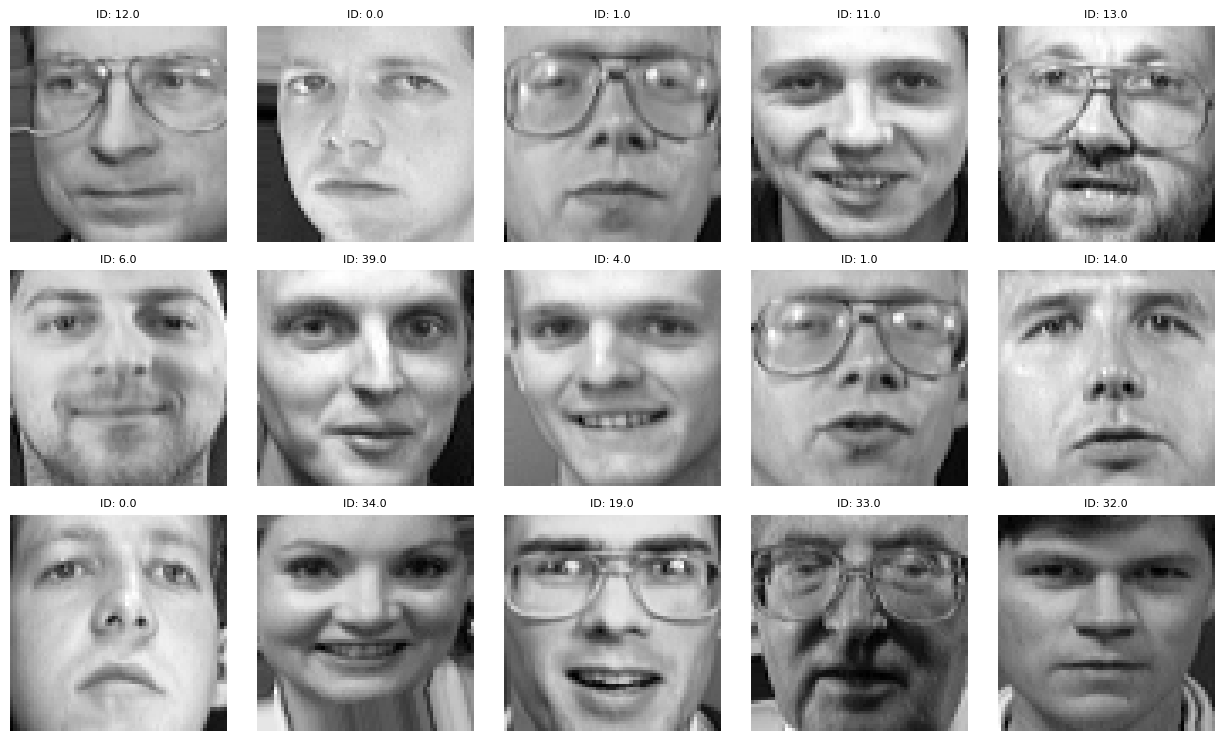

In [ ]:
plot_random_img(train)

### PCA:

In [ ]:
import numpy as np

class PCAFromScratch:
    def __init__(self, n_components, center=True, scale=False):
        self.n_components = n_components
        self.center = center
        self.scale = scale
        self.mean_ = None
        self.scale_ = None
        self.components_ = None
        self.singular_values_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X_train):
        X = np.asarray(X_train, dtype=float)
        n, p = X.shape
        self.mean_ = X.mean(axis=0) if self.center else np.zeros(p)
        Xc = X - self.mean_
        if self.scale:
            self.scale_ = Xc.std(axis=0, ddof=1)
            self.scale_[self.scale_ == 0] = 1.0
            Xc = Xc / self.scale_
        else:
            self.scale_ = np.ones(p)

        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)   # Xc = U S V^T
        k = self.n_components
        self.components_ = Vt[:k]
        self.singular_values_ = S[:k]

        eigvals = (S**2) / (n - 1)
        self.explained_variance_ = eigvals[:k]
        self.explained_variance_ratio_ = eigvals[:k] / eigvals.sum()
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        Xc = (X - self.mean_) / self.scale_
        return Xc @ self.components_.T

    def fit_transform(self, X_train):
        return self.fit(X_train).transform(X_train)

    def inverse_transform(self, Z):
        Xc_rec = Z @ self.components_
        return Xc_rec * self.scale_ + self.mean_


In [ ]:
def pca_fit_select_transform(X_train, X_test=None, threshold=0.90,
                             center=True, scale=False, plot=True, random_state=None):
    """
    Ajusta PCA en TRAIN con todos los componentes, grafica varianza explicada acumulada,
    elige k mínimo que alcanza >= threshold, y transforma TRAIN/TEST con esos k.

    Devuelve: dict con k, curva acumulada, pca_truncado, Z_train, Z_test (si se pasó).
    """
    X_train = np.asarray(X_train, dtype=float)
    if X_test is not None:
        X_test = np.asarray(X_test, dtype=float)

    # 1) PCA completo en TRAIN
    k_full = min(X_train.shape[0], X_train.shape[1])
    pca_full = PCAFromScratch(n_components=k_full, center=center, scale=scale)
    pca_full.fit(X_train)

    # 2) Varianza explicada acumulada y k*
    cum = np.cumsum(pca_full.explained_variance_ratio_)
    k_star = int(np.searchsorted(cum, threshold) + 1)

    # 3) Plot
    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(np.arange(1, len(cum)+1), cum, marker='o')
        ax.axhline(threshold, linestyle='--')
        ax.axvline(k_star, linestyle='--')
        ax.scatter([k_star], [cum[k_star-1]], s=60, zorder=3)
        ax.set_xlabel('Número de componentes')
        ax.set_ylabel('Varianza explicada acumulada')
        ax.set_ylim(0, 1.01)
        ax.set_title('Curva de varianza explicada')
        fig.tight_layout()
        plt.show()

    # 4) Construir un PCA truncado a k*
    pca_k = PCAFromScratch(n_components=k_star, center=center, scale=scale)
    pca_k.mean_  = pca_full.mean_
    pca_k.scale_ = pca_full.scale_
    pca_k.components_ = pca_full.components_[:k_star]
    pca_k.singular_values_ = pca_full.singular_values_[:k_star]
    pca_k.explained_variance_ = pca_full.explained_variance_[:k_star]
    pca_k.explained_variance_ratio_ = pca_full.explained_variance_ratio_[:k_star]

    # 5) Transformar TRAIN/TEST con k*
    Z_train = pca_k.transform(X_train)
    Z_test  = pca_k.transform(X_test) if X_test is not None else None

    return {
        "k": k_star,
        "cum_explained_variance": cum,
        "pca": pca_k,
        "Z_train": Z_train,
        "Z_test": Z_test
    }

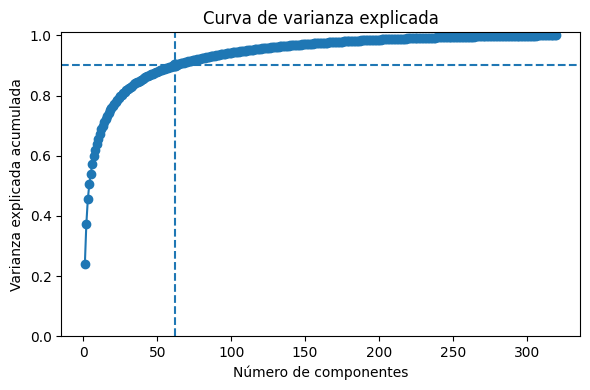

k elegido: 62


In [ ]:
res = pca_fit_select_transform(x_train, x_val, threshold=0.90, center=True,
                               scale=False, plot=True)


k = res["k"]
Z_train, Z_test = res["Z_train"], res["Z_test"]
pca_90 = res["pca"]
print("k elegido:", res["k"])

#### comparar imagenes

In [ ]:
def compare_recon_by_k64_simple(pca, X, k_list, n=6, seed=0):
    X = np.asarray(X, float)
    idx = np.random.default_rng(seed).choice(len(X), size=min(n, len(X)), replace=False)
    mu, sc, V = pca.mean_, pca.scale_, pca.components_
    cols = 1 + len(k_list)
    fig, ax = plt.subplots(len(idx), cols, figsize=(2.2*cols, 2.2*len(idx)))
    ax = np.atleast_2d(ax)

    for r, i in enumerate(idx):
        ax[r,0].imshow(X[i].reshape(64,64), cmap='gray'); ax[r,0].axis('off'); ax[r,0].set_title('Orig', fontsize=9)
        Xc = (X[i] - mu) / sc
        for c, k in enumerate(k_list, start=1):
            Vk = V[:k]
            rec = ((Xc @ Vk.T) @ Vk) * sc + mu
            ax[r,c].imshow(rec.reshape(64,64), cmap='gray'); ax[r,c].axis('off'); ax[r,c].set_title(f'k={k}', fontsize=9)

    plt.tight_layout(); plt.show()

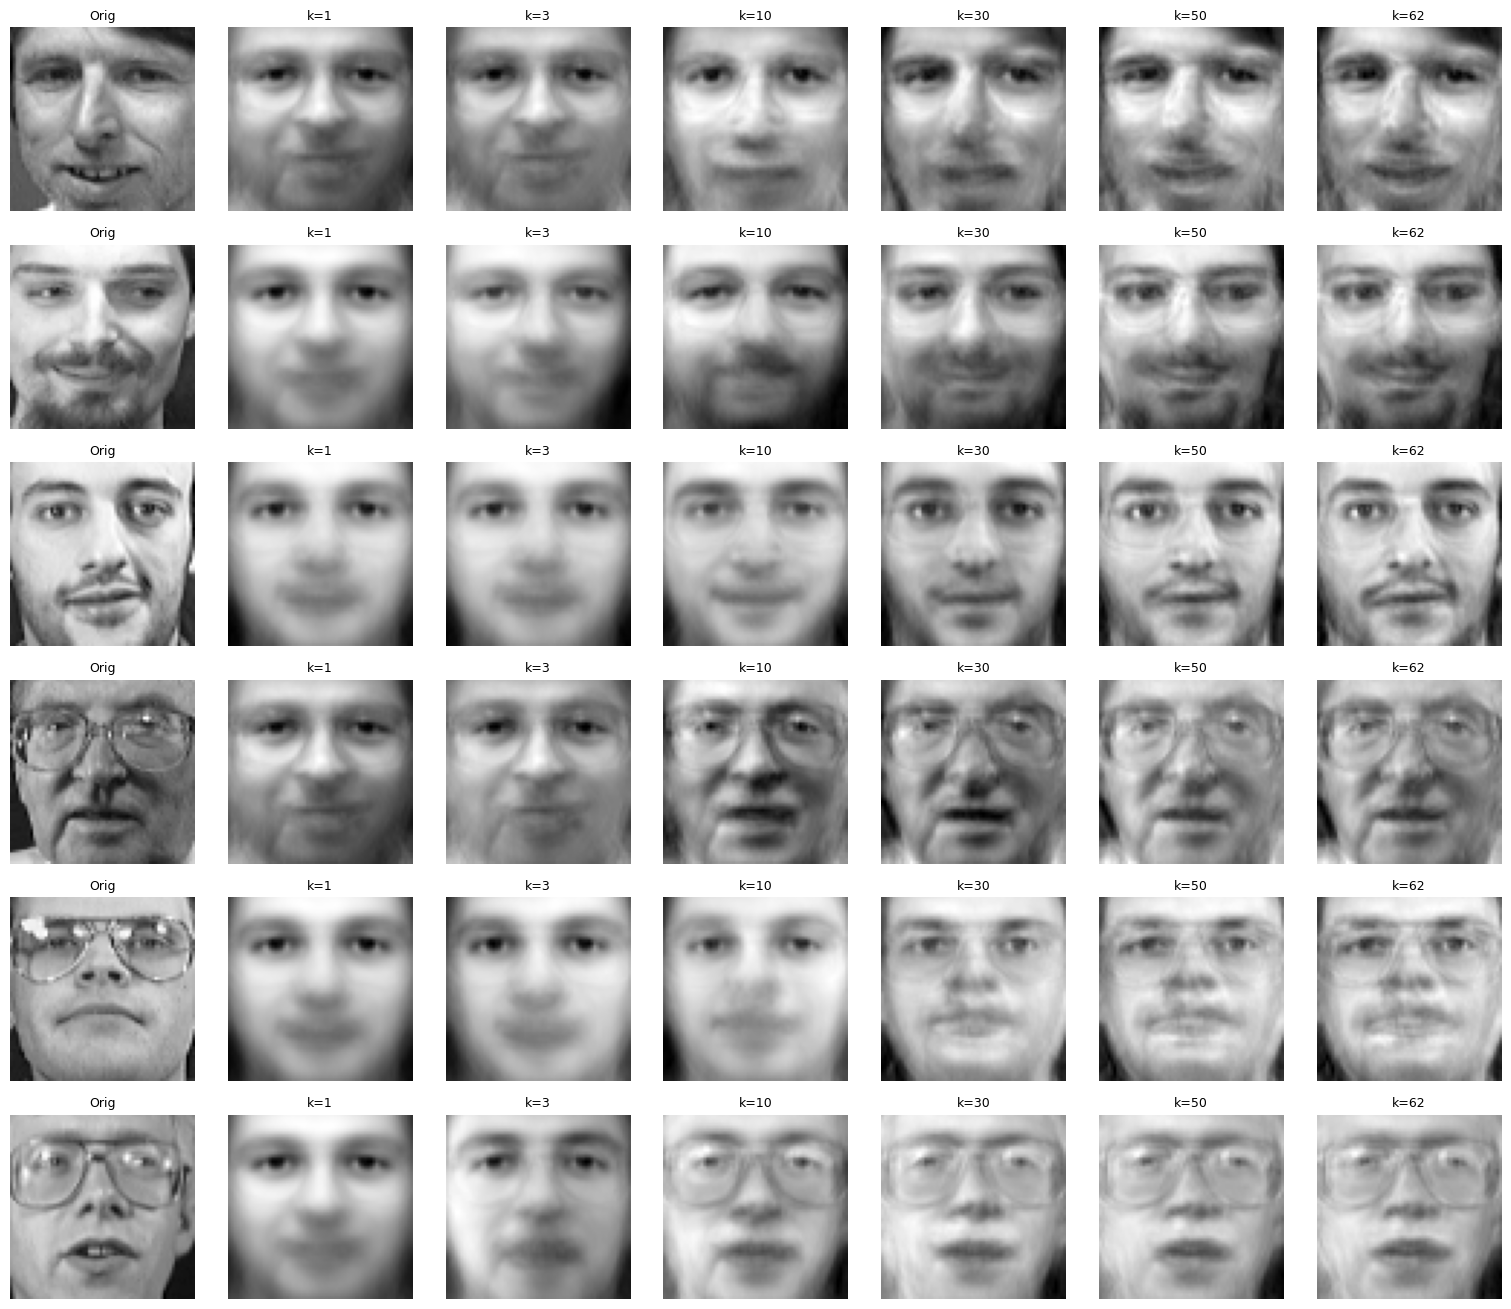

In [ ]:
compare_recon_by_k64_simple(pca_90, x_val, k_list=[1, 3, 10, 30, 50, k], n=6, seed=7)

## Auto Encoder


Entrenar un modelo de autoencoder deterministico (AE) utilizando la librería PyTorch para armar y entrenar las redes neuronales involucradas (la red de encoder y la de decoder). Para hacer una comparacion justa, la dimension latente debe ser la misma que la obtenida en el PCA. Recuerde dividir el conjunto de datos en dos subconjuntos: entrenamiento y validación, los mismos utilizados para el PCA. El subconjunto de entrenamiento se empleará para entrenar el AE, mientras que el de validación servirá para ajustar los hiperparámetros (regularizacion, arquitectura o lo que considere) y evaluar el error de reconstrucción.

In [ ]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

Usando: cuda


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=4096, latent_dim=62):
        super().__init__()
        # ----- ENCODER -----
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2048), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(2048, 1080), nn.GELU(), nn.LayerNorm(1080),
            nn.Linear(1080, 128), nn.GELU(),
            nn.Linear(128, latent_dim)
        )
        # ----- DECODER -----
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 224), nn.GELU(),
            nn.Linear(224, 1080), nn.GELU(),
            nn.Linear(1080, 2048), nn.GELU(),
            nn.Linear(2048, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

In [ ]:
def train_ae(X_train, X_valid, k, epochs=300, bs=128, lr=1e-4, weight_decay=1e-5):
    # 1) Centrar con la media del TRAIN (igual que PCA)
    X_train = X_train.astype(np.float32)
    X_valid = X_valid.astype(np.float32)
    mu = X_train.mean(0, keepdims=True).astype(np.float32)
    Xtr = X_train - mu
    Xva = X_valid - mu

    # 2) DataLoaders
    tr = DataLoader(TensorDataset(torch.from_numpy(Xtr)), batch_size=bs, shuffle=True)
    va = DataLoader(TensorDataset(torch.from_numpy(Xva)), batch_size=bs, shuffle=False)

    # 3) Modelo + optimizador
    model = AutoEncoder(input_dim=Xtr.shape[1], latent_dim=k).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.MSELoss()

    # 4) Loop (sencillo)
    model.train()
    for _ in range(epochs):
        for (xb,) in tr:
            xb = xb.to(device)
            xhat, _ = model(xb)
            loss = crit(xhat, xb)
            opt.zero_grad(); loss.backward(); opt.step()

    # Validación rápida
    model.eval()
    with torch.no_grad():
        vxb = torch.from_numpy(Xva).to(device)
        vhat, _ = model(vxb)
        val_mse = crit(vhat, vxb).item()

    return model, mu, val_mse

def ae_encode(model, X, mu):
    Xc = X.astype(np.float32) - mu.astype(np.float32).reshape(1, -1)
    model.eval()
    with torch.no_grad():
        z = model.encoder(torch.from_numpy(Xc).to(device)).detach().cpu().numpy()
    return z

@torch.no_grad()
def ae_reconstruct(model, X, mu):
    Xc = (X.astype(np.float32) - mu)
    xhat_c, _ = model(torch.from_numpy(Xc).to(device))
    return xhat_c.cpu().numpy() + mu

In [ ]:
ae_model, ae_mu, ae_mse = train_ae(x_train, x_val, k)

In [ ]:
def comp_pca_ae64(pca, ae, X_valid, mu_ae, n=10, seed=0):
    X_valid = np.asarray(X_valid, np.float32)
    idx = np.random.default_rng(seed).choice(len(X_valid), size=min(n, len(X_valid)), replace=False)
    X = X_valid[idx]

    Xp = pca.inverse_transform(pca.transform(X)).astype(np.float32)

    dev = next(ae.parameters()).device
    with torch.no_grad():
      x_hat, _ = ae(torch.from_numpy(X - mu_ae).to(dev))
      Xae = x_hat.cpu().numpy().astype(np.float32) + mu_ae

    print(f"MSE PCA: {np.mean((X - Xp)**2):.6f} | MSE AE: {np.mean((X - Xae)**2):.6f}")

    fig, ax = plt.subplots(len(idx), 3, figsize=(7, 2.1*len(idx)))
    ax = np.atleast_2d(ax)
    for r in range(len(idx)):
        ax[r,0].imshow(X[r].reshape(64,64), cmap='gray');  ax[r,0].axis('off'); ax[r,0].set_title('Orig', fontsize=9)
        ax[r,1].imshow(Xp[r].reshape(64,64), cmap='gray'); ax[r,1].axis('off'); ax[r,1].set_title('PCA',  fontsize=9)
        ax[r,2].imshow(Xae[r].reshape(64,64), cmap='gray'); ax[r,2].axis('off'); ax[r,2].set_title('AE',   fontsize=9)
    plt.tight_layout(); plt.show()

MSE PCA: 0.002829 | MSE AE: 0.004240


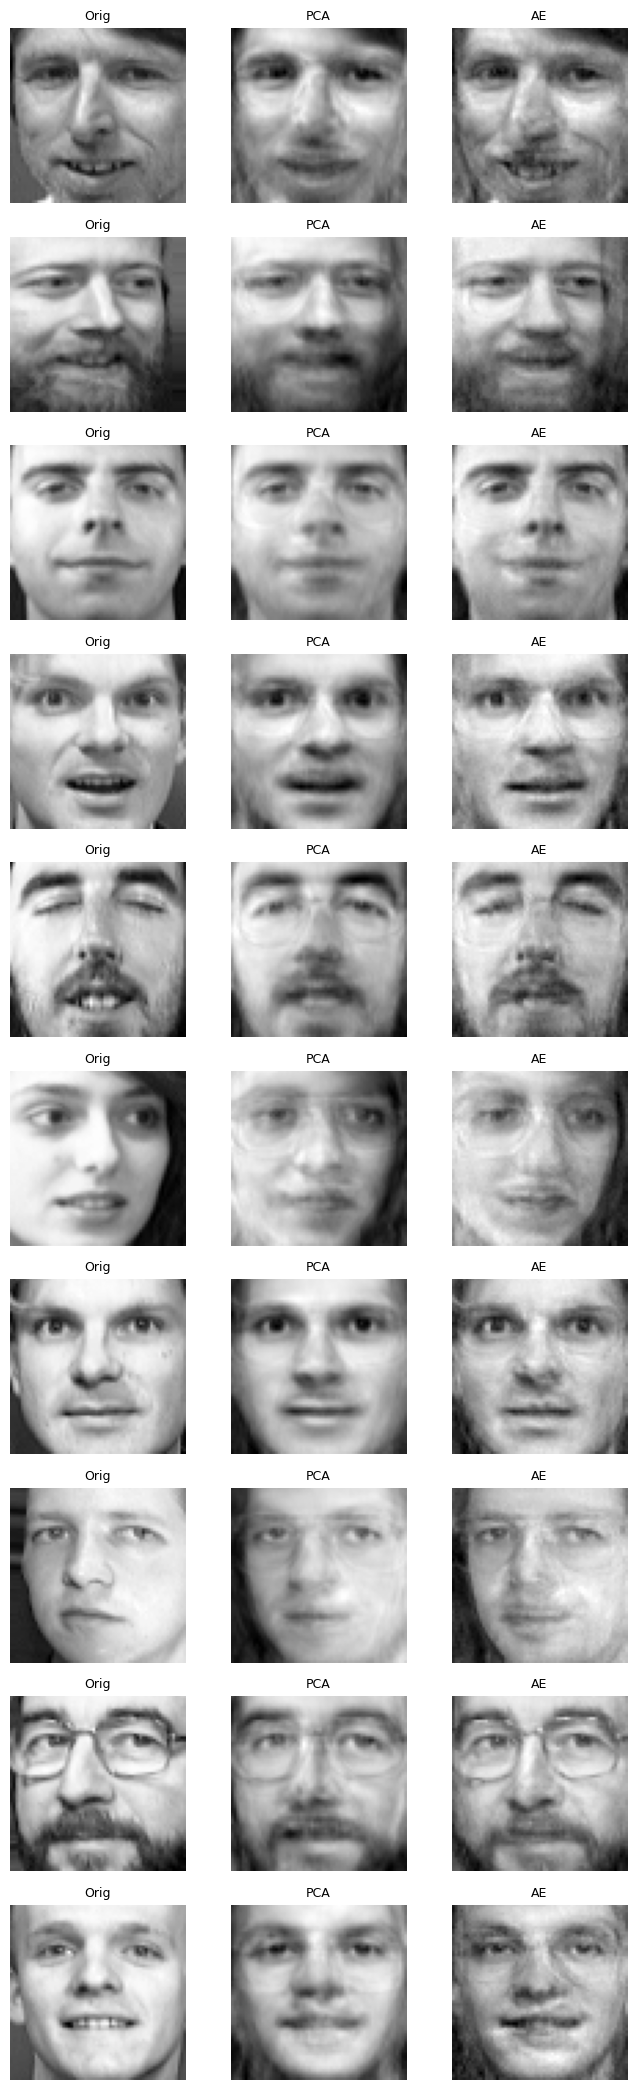

In [ ]:
comp_pca_ae64(pca_90, ae_model, x_val, ae_mu, n=10, seed=7)

# Clustering

In [ ]:
X_all = ds.drop(columns=['person_id']).to_numpy()
Z_all_pca = pca_90.transform(X_all)
Z_all_ae  = ae_encode(ae_model, X_all, ae_mu)

##  a) K-Means
Desarrollar una funcion que implemente el algoritmo k-Means. Probar con valores de K
 dentro del rango de [5,20].

In [ ]:
# --- k-means++ inicialización ---
def _kpp_init(X, k, rng):
    n = X.shape[0]
    centroids = np.empty((k, X.shape[1]), dtype=X.dtype)
    i0 = rng.integers(0, n)
    centroids[0] = X[i0]
    d2 = np.sum((X - centroids[0])**2, axis=1)
    for j in range(1, k):
        probs = d2 / (d2.sum() + 1e-12)
        idx = rng.choice(n, p=probs)
        centroids[j] = X[idx]
        d2 = np.minimum(d2, np.sum((X - centroids[j])**2, axis=1))
    return centroids

# --- k-means principal ---
def kmeans(X, k, n_init=10, max_iter=300, tol=1e-4, seed=None, init="kmeans++"):
    rng = np.random.default_rng(seed)
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    best_inertia, best = np.inf, None

    for _ in range(n_init):
        C = _kpp_init(X, k, rng) if init=="kmeans++" else X[rng.choice(n, k, replace=False)].copy()
        labels = np.full(n, -1, int)

        for _ in range(max_iter):
            # asignación
            d2 = np.sum((X[:, None, :] - C[None, :, :])**2, axis=2)  # (n,k)
            new_labels = d2.argmin(axis=1)
            if np.array_equal(new_labels, labels): break
            labels = new_labels

            # actualización
            C_new = C.copy()
            for j in range(k):
                mask = (labels == j)
                if mask.any():
                    C_new[j] = X[mask].mean(axis=0)
                else:
                    # clúster vacío -> reini
                    C_new[j] = X[rng.integers(0, n)]
            shift = np.sqrt(((C_new - C)**2).sum(axis=1)).max()
            C = C_new
            if shift < tol: break

        inertia = ((X - C[labels])**2).sum()
        if inertia < best_inertia:
            best_inertia, best = inertia, (C.copy(), labels.copy())

    C, labels = best
    return {"centroids": C, "labels": labels, "inertia": float(best_inertia)}

def kmeans_try_range(X, k_min=5, k_max=20, **kwargs):
    X = np.asarray(X, dtype=float)
    Ks, inertias = [], []
    for K in range(k_min, k_max+1):
        res = kmeans(X, K, **kwargs)
        Ks.append(K); inertias.append(res["inertia"])
        print(f"K={K:2d}  Inercia={res['inertia']:.4f}")
    plt.figure(figsize=(5,3))
    plt.plot(Ks, inertias, marker='o')
    plt.xlabel('K'); plt.ylabel('Inercia (SSE)'); plt.title('Método del codo')
    plt.xticks(Ks); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()
    return Ks, inertias

en las consignas dice entre 5 y 20 pero no llego a percibir el elbow

K= 5  Inercia=18034.0185
K= 6  Inercia=17375.2815
K= 7  Inercia=16876.4872
K= 8  Inercia=16396.3497
K= 9  Inercia=16042.8595
K=10  Inercia=15452.5008
K=11  Inercia=14954.1293
K=12  Inercia=14905.5823
K=13  Inercia=14536.9943
K=14  Inercia=14320.4874
K=15  Inercia=13900.5695
K=16  Inercia=13565.1582
K=17  Inercia=13333.5570
K=18  Inercia=13062.2067
K=19  Inercia=12803.5552
K=20  Inercia=12536.0795


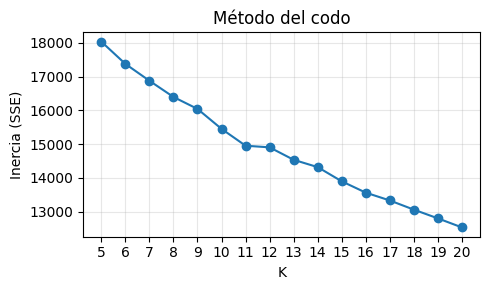

In [ ]:
res = kmeans_try_range(Z_all_pca, k_min=5, k_max=20)

## GMM
Desarrollar una funcion que implemente el algoritmo GMM. Probar con valores de K dentro del rango de [5,20].

In [ ]:
import numpy as np

def _logsumexp(a, axis=1):
    m = np.max(a, axis=axis, keepdims=True)
    return (m + np.log(np.exp(a - m).sum(axis=axis, keepdims=True))).squeeze(axis)

def gmm_diag_simple(X, k, max_iter=500, tol=1e-4, seed=0, var_floor=1e-6):
    X = np.asarray(X, float)
    n, d = X.shape
    rng = np.random.default_rng(seed)

    # init simple
    mu  = X[rng.choice(n, k, replace=False)].copy()      # (k,d)
    var = np.tile(X.var(0, keepdims=True), (k,1))        # (k,d)
    pi  = np.full(k, 1.0/k)

    const = d * np.log(2*np.pi)
    prev_ll = -np.inf

    for _ in range(max_iter):
        # E-step: responsabilidades
        diff = X[:, None, :] - mu[None, :, :]            # (n,k,d)
        log_pdf = -0.5*(const + np.log(var+var_floor).sum(1)[None,:]
                        + ((diff**2)/(var[None,:,:]+var_floor)).sum(2))          # (n,k)
        log_w = np.log(pi + 1e-12)[None,:] + log_pdf                              # (n,k)
        log_p = _logsumexp(log_w, axis=1)                                         # (n,)
        resp  = np.exp(log_w - log_p[:, None])                                    # (n,k)
        ll = float(log_p.sum())
        if ll - prev_ll <= tol * (abs(prev_ll) + 1.0): break
        prev_ll = ll

        # M-step
        Nk  = resp.sum(0) + 1e-12                     # (k,)
        pi  = Nk / n
        mu  = (resp.T @ X) / Nk[:, None]
        diff = X[:, None, :] - mu[None, :, :]
        var = (resp[:, :, None] * (diff**2)).sum(0) / Nk[:, None]
        var = np.maximum(var, var_floor)

    labels = resp.argmax(1)
    p = k*(2*d) + (k-1)       # parámetros (diag)
    bic = -2*ll + p*np.log(n)
    aic = -2*ll + 2*p
    return {"pi":pi, "mu":mu, "var":var, "labels":labels, "loglik":ll, "bic":bic, "aic":aic}

def gmm_try_range(X, k_min=5, k_max=20, seed=0):
    Ks, bics, aics = [], [], []
    for K in range(k_min, k_max+1):
        res = gmm_diag_simple(X, K, seed=seed)
        Ks.append(K); bics.append(res["bic"]); aics.append(res["aic"])
        print(f"K={K:2d}  BIC={res['bic']:.2f}  AIC={res['aic']:.2f}")
    return np.array(Ks), np.array(bics), np.array(aics)


In [ ]:
Ks, BICs, AICs = gmm_try_range(Z_all_pca, k_min=5, k_max=20, seed=7)
k_bic = Ks[BICs.argmin()]
print("Mejor K por BIC:", k_bic)

K= 5  BIC=63816.10  AIC=61325.43
K= 6  BIC=66524.26  AIC=63534.65
K= 7  BIC=65850.67  AIC=62362.13
K= 8  BIC=64405.26  AIC=60417.79
K= 9  BIC=64674.09  AIC=60187.68
K=10  BIC=67196.63  AIC=62211.29
K=11  BIC=67168.47  AIC=61684.20
K=12  BIC=67539.17  AIC=61555.97
K=13  BIC=67922.20  AIC=61440.06
K=14  BIC=69006.49  AIC=62025.42
K=15  BIC=71012.14  AIC=63532.14
K=16  BIC=71509.29  AIC=63530.35
K=17  BIC=71954.99  AIC=63477.12
K=18  BIC=70955.79  AIC=61978.99
K=19  BIC=71965.57  AIC=62489.83
K=20  BIC=72035.05  AIC=62060.38
Mejor K por BIC: 5


In [ ]:
def silhouette_score(X, labels):
    X = np.asarray(X, float)
    n = X.shape[0]
    # distancias euclídeas por producto punto
    x2 = (X*X).sum(1, keepdims=True)
    D2 = x2 + x2.T - 2*X@X.T
    np.maximum(D2, 0, out=D2)
    D = np.sqrt(D2, dtype=float)

    # clusters
    uniq = np.unique(labels)
    K = len(uniq)
    # matriz indicador (n x K)
    M = np.zeros((n, K), float)
    lbl2idx = {c:j for j,c in enumerate(uniq)}
    idx_lbl = np.array([lbl2idx[c] for c in labels])
    M[np.arange(n), idx_lbl] = 1.0
    counts = M.sum(0)  # (K,)

    # suma de distancias a cada cluster para cada punto: S = D @ M
    S = D @ M  # (n x K)
    means = S / np.maximum(counts, 1e-12)

    # a(i): misma clase (excluye a sí mismo)
    a = np.zeros(n, float)
    same_cnt = counts[idx_lbl]
    mask = same_cnt > 1
    a[mask] = S[np.arange(n), idx_lbl][mask] / (same_cnt[mask] - 1)

    # b(i): mejor cluster alternativo
    means_alt = means.copy()
    means_alt[np.arange(n), idx_lbl] = np.inf
    b = np.min(means_alt, axis=1)

    # silhouette: 0 para clusters de un solo punto
    s = np.zeros(n, float)
    den = np.maximum(np.maximum(b, a), 1e-12)
    s[mask] = (b[mask] - a[mask]) / den[mask]
    return float(np.mean(s))


def elbow_y_silhouette(X, Ks, **km_kwargs):
    inertias, sils = [], []
    for K in Ks:
        res = kmeans(X, K, **km_kwargs)          # tu función
        inertias.append(res["inertia"])
        if silhouette_score is not None:
            sils.append(silhouette_score(X, res["labels"]))
    inertias = np.array(inertias, float)
    gains = np.r_[np.nan, inertias[:-1] - inertias[1:]]   # ΔSSE = SSE(K-1)-SSE(K)
    sils = np.array(sils, float) if sils else None
    return inertias, gains, sils

def plot_elbow_sil(Ks, gains, sils=None):
    plt.figure(figsize=(9,3.5))
    plt.subplot(1,2,1)
    plt.plot(Ks, gains, marker='o'); plt.title("Ganancia marginal ΔSSE")
    plt.xlabel("K"); plt.ylabel("Δ Inercia"); plt.grid(alpha=.3)
    plt.subplot(1,2,2)
    if sils is not None:
        plt.plot(Ks, sils, marker='o'); plt.ylabel("Silhouette")
    else:
        plt.text(0.5,0.5,"(sin sklearn)\nno se calculó Silhouette", ha='center', va='center')
        plt.axis('off')
    plt.xlabel("K"); plt.title("Silhouette"); plt.grid(alpha=.3)
    plt.tight_layout(); plt.show()

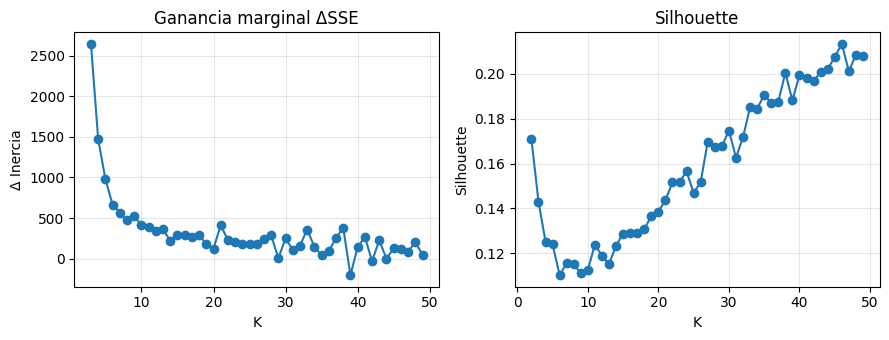

In [ ]:
Ks = list(range(2,50))
inertias, gains, sils = elbow_y_silhouette(Z_all_pca, Ks, n_init=80, max_iter=800, tol=1e-5, seed=7)
plot_elbow_sil(Ks, gains, sils)

In [ ]:
rel_gain = (np.array(inertias[:-1])-np.array(inertias[1:]))/np.array(inertias[:-1])
K_elbow = Ks[1:][np.argmax(rel_gain < 0.05)]

# 2) K_sil: K que maximiza silhouette
K_sil = Ks[np.argmax(sils)]

print("K elbow:", K_elbow, "| K silhouette:", K_sil)

K elbow: 6 | K silhouette: 46


## Analisis

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

BEST_K = K_sil
PCA_PREFIT = pca_90
RANDOM_STATE = 42

def reduce_to_2d(X, pca_prefit=None):
    """
    Usa el PCA preentrenado si se provee y tiene al menos 2 componentes.
    Si no, entrena un PCA(n_components=2) solo para visualización.
    """
    Z = pca_prefit.transform(X)
    pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
    return pca2.fit_transform(X)

def cluster_and_report(ds, best_k, pca_prefit=None, random_state=42, show=True):
    y = ds['person_id'].to_numpy()
    X = ds.drop(columns=['person_id']).to_numpy(dtype=float)
    Z2 = reduce_to_2d(X, pca_prefit=pca_prefit)

    kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=random_state)
    y_pred = kmeans.fit_predict(X)

    # --- métricas globales vs. clases reales ---
    ari = adjusted_rand_score(y, y_pred)
    nmi = normalized_mutual_info_score(y, y_pred)
    # silhouette en el espacio original; si es muy pesado, podrías usar Z2
    try:
        sil = silhouette_score(X, y_pred)
    except Exception:
        sil = silhouette_score(Z2, y_pred)

    # --- tablas ---
    sizes = pd.Series(y_pred).value_counts().sort_index()
    ctab = pd.crosstab(pd.Series(y_pred, name='cluster'),
                       pd.Series(y, name='clase')).sort_index()

    # pureza por cluster = max clase del cluster / tamaño del cluster
    max_in_cluster = ctab.max(axis=1)
    purity_per_cluster = (max_in_cluster / sizes).rename("pureza_cluster")
    # pureza global = suma de máximos / total
    overall_purity = max_in_cluster.sum() / len(y)

    # --- impresión resumen ---
    print("=== Métricas globales ===")
    print(f"ARI: {ari:.3f} | NMI: {nmi:.3f} | Silhouette: {sil:.3f} | Pureza global: {overall_purity:.3f}\n")

    print("=== Tamaños por cluster ===")
    display(sizes.to_frame("n_muestras"))

    print("\n=== Contingencia (cluster x clase) ===")
    display(ctab)

    print("\n=== Pureza por cluster ===")
    display(purity_per_cluster.to_frame())

    # --- gráficos ---
    if show:
        # 1) scatter 2D por cluster
        plt.figure(figsize=(6,5))
        sc = plt.scatter(Z2[:,0], Z2[:,1], c=y_pred, s=12)
        plt.xlabel('Componente 1'); plt.ylabel('Componente 2')
        plt.title(f'Embeddings 2D (PCA) coloreados por cluster (K={best_k})')
        plt.tight_layout(); plt.show()

        # 2) scatter 2D por clase real (para comparar)
        # mapeamos clases a enteros para colorear
        clases_unicas, y_int = np.unique(y, return_inverse=True)
        plt.figure(figsize=(6,5))
        sc2 = plt.scatter(Z2[:,0], Z2[:,1], c=y_int, s=12)
        plt.xlabel('Componente 1'); plt.ylabel('Componente 2')
        plt.title('Embeddings 2D (PCA) coloreados por clase real')
        plt.tight_layout(); plt.show()

        # 3) barras: tamaño por cluster
        plt.figure(figsize=(6,3))
        plt.bar(sizes.index.astype(str), sizes.values, width=0.9, edgecolor='black')
        plt.xlabel('Cluster'); plt.ylabel('Cantidad')
        plt.title('Tamaño de cada cluster')
        plt.tight_layout(); plt.show()

    # Devolver todo por si querés seguir analizando
    return {
        "Z2": Z2,
        "y_pred": y_pred,
        "sizes": sizes,
        "contingencia": ctab,
        "pureza_por_cluster": purity_per_cluster,
        "purity_global": overall_purity,
        "ARI": ari,
        "NMI": nmi,
        "silhouette": sil
    }

res = cluster_and_report(ds, BEST_K, pca_prefit=PCA_PREFIT, random_state=RANDOM_STATE, show=True)
